# Understanding the similarity threshold

Defining a threshold is no easy task. There is not a specific criteria. In that regard, several approaches are developed in order to present all scenarios involved in the definition.

In [1]:
### Import packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Define constants

MATCHED_INGREDIENTS_TABLE = 'kp_ingredients_nutrition'

PLOT_SETUP = {'title': 20,
              'subtitle': 18,
              'label': 16,
              'legend': 14,
              'tick': 14}

In [3]:
### Define functions
def generate_string_connection():
    
    # Retrieve params from env
    DB_HOST = os.environ['DB_HOST_STAGE']
    DB_NAME = os.environ['DB_NAME_STAGE']
    DB_PORT = os.environ['DB_PORT_STAGE']
    DB_USERNAME = os.environ['DB_USERNAME_STAGE']
    DB_PASSWORD = os.environ['DB_PASSWORD_STAGE']
    
    # Create string
    string_conn = f'mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    
    return string_conn;

def load_df_from_sql(tableName, string_conn):
    
    sqlEngine = create_engine(string_conn)
    dbConnection = sqlEngine.connect()
    
    try:
        df = pd.read_sql_table(tableName, dbConnection)
        print(f'Query successfully executed for table {tableName}')
        return df;

    except Exception as ex:   
        print(ex)

    finally:
        dbConnection.close();

In [4]:
### Define string connection

STRING_CONN = generate_string_connection()

In [5]:
### Retrieve main table

df_main = load_df_from_sql(MATCHED_INGREDIENTS_TABLE, STRING_CONN)

DF_ROWS = len(df_main)

df_main.head()

Query successfully executed for table kp_ingredients_nutrition


,ingredient_id,original_ingredient_name,matched_ingredient,matched_score,ingredient_category_id,taxonomy_category_id,nutrition_id,has_nutrition_data,energy_quantity,energy_unit,...,salt_quantity,salt_unit,fat_quantity,fat_unit,saturated_fat_quantity,saturated_fat_unit,carbohydrate_quantity,carbohydrate_unit,sugar_quantity,sugar_unit
0,640848,Young's Breaded White Fish Fishcakes,wrekin-white,0.576438,101,107,892464,1,239,kcal,...,1.28,g,11.5,g,1.1,g,24.1,g,0.6,g
1,640849,Msc Breaded White Fish Fillet 50-70g,cod-fillets,0.741485,101,101,892465,1,199,kcal,...,0.35,g,9,g,0.7,g,21.5,g,0.7,g
2,640850,Pier 7 Raw Scottish Salmon Portions Skinless 1...,canned-salmons,0.847515,101,101,892466,1,217,kcal,...,0.3,g,14.8,g,2.6,g,0,g,0,g
3,640912,GG Pickled cockles,pickled-peppers,0.759848,101,103,892528,1,None,None,...,None,None,None,None,None,None,None,None,None,None
4,640915,GG Mussels,mussels,1.000000,101,101,892531,1,None,None,...,None,None,None,None,None,None,None,None,None,None


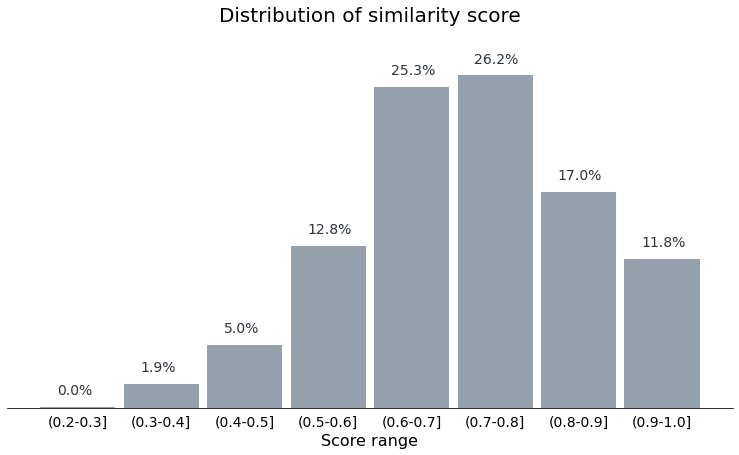

In [6]:
### Plot score histogram

df_histogram = df_main[['matched_score']]

# Round score
df_histogram['round_score'] = np.ceil(df_histogram['matched_score'] * 10) / 10
df_histogram.loc[df_histogram['round_score'] <= 0, 'round_score'] = 0
df_histogram.loc[df_histogram['round_score'] >= 1, 'round_score'] = 1

# Group results
df_histogram_grouped = df_histogram[['round_score']].groupby('round_score', as_index = False).size()
df_histogram_grouped['freq'] = df_histogram_grouped['size'] / DF_ROWS

# Generate axis
df_histogram_grouped['right_label'] = df_histogram_grouped['round_score'].apply(str)
df_histogram_grouped['left_label'] = round(df_histogram_grouped['round_score'] - 0.1, 1).apply(str)
df_histogram_grouped['label'] = '(' + df_histogram_grouped['left_label'] + '-' + df_histogram_grouped['right_label'] + ']'

# Define plot consants
WIDTH = 0.9
COLOUR = '#708090'
TEXT_COLOUR = '#2d343a'
ALPHA = 0.75
Y_MAX = round(np.ceil(df_histogram_grouped['freq'].max() / 0.05) * 0.05, 2)
X_POS_DELTA = 0.25
Y_POS_DELTA = -0.01

# Plot histogram
fig = plt.figure(1, (13, 7))
ax = fig.add_subplot(1, 1, 1)

ax.bar(df_histogram_grouped.index.values,
      df_histogram_grouped['freq'],
      width = WIDTH,
      color = COLOUR,
      alpha = ALPHA)

# Format x labels
ax.set_xticks(df_histogram_grouped.index)
ax.set_xticklabels(df_histogram_grouped['label'])
ax.tick_params(axis = 'x', which = 'both', bottom = False, labelsize = PLOT_SETUP['tick'])

# Format y range
ax.set_ylim([0, Y_MAX])
ax.tick_params(axis = 'y', which = 'major', labelleft = False, left = False)

# Format labels and plot
ax.set_title('Distribution of similarity score', fontsize = PLOT_SETUP['title'])
ax.set_xlabel('Score range', fontsize = PLOT_SETUP['label'])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add text
for x, y in enumerate(df_histogram_grouped['freq']):
    ax.text(x - X_POS_DELTA,
            y - Y_POS_DELTA,
            '{:.1%}'.format(y),
            color = TEXT_COLOUR,
            fontsize = PLOT_SETUP['legend'])

plt.show()

In [7]:
### Build dataframe with varying score

INIT_INGREDIENTS = len(df_main['matched_ingredient'].unique())

# Initialise dict
dict_sensibility = {}

dict_sensibility['cutoff_score'] = np.linspace(0, 1, 101)
dict_sensibility['ingredients'] = []
dict_sensibility['preserved_rows'] = []
dict_sensibility['ingredients_retained'] = []
dict_sensibility['category_match'] = []
dict_sensibility['null_energy'] = []
dict_sensibility['mean_volatility'] = []

# Compute metrics
for threshold in dict_sensibility['cutoff_score']:

    # Slice dataframe
    df_sliced = df_main[df_main['matched_score'] >= threshold]

    # Count rows
    N_ROWS = len(df_sliced)

    # Different ingredients
    NUM_INGREDIENTS = len(df_sliced['matched_ingredient'].unique())

    # Category match
    MATCH = sum(df_sliced['ingredient_category_id'] == df_sliced['taxonomy_category_id'])

    # Null energy
    NULL_ENERGY = sum(df_sliced['energy_quantity'].isnull())

    # Volatility of ingredients - energy
    df_ingredients = df_sliced[df_sliced['energy_unit'] == 'kcal']
    df_ingredients['energy_quantity'] = pd.to_numeric(df_ingredients['energy_quantity'])

    df_ingredients = df_ingredients[['matched_ingredient', 'energy_quantity']].groupby('matched_ingredient').agg('std')
    df_ingredients['energy_quantity'].fillna(0, inplace = True)
    df_ingredients.rename(columns = {'energy_quantity': 'energy_std'}, inplace = True)

    MEAN_VOLATILITY = np.mean(df_ingredients['energy_std'])

    # Update list
    dict_sensibility['ingredients'].append(N_ROWS)
    dict_sensibility['preserved_rows'].append(N_ROWS / DF_ROWS)
    dict_sensibility['ingredients_retained'].append(NUM_INGREDIENTS / INIT_INGREDIENTS)
    dict_sensibility['category_match'].append(MATCH / N_ROWS)
    dict_sensibility['null_energy'].append(NULL_ENERGY / N_ROWS)
    dict_sensibility['mean_volatility'].append(MEAN_VOLATILITY)

# Compute dataframe
df_sensibility = pd.DataFrame(dict_sensibility)

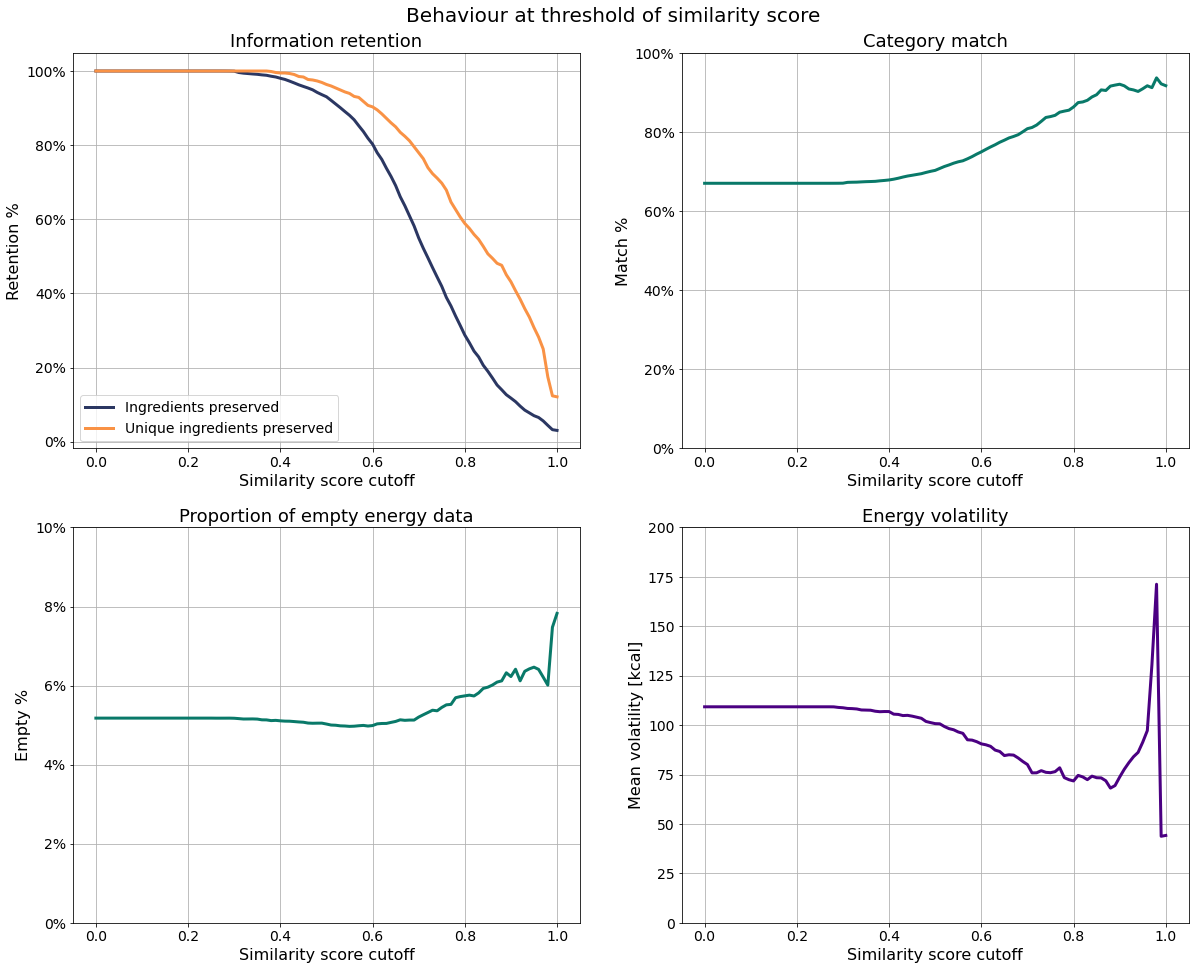

In [8]:
### Plot results

fig, axs = plt.subplots(2, 2, figsize = (20, 16))
X_LABEL = 'Similarity score cutoff'
LINEWIDTH = 3
VISIBILITY = True

# Plot retention
axs[0, 0].plot(df_sensibility['cutoff_score'],
              df_sensibility['preserved_rows'] * 100,
              color = '#2b3762',
              label = 'Ingredients preserved',
              lw = LINEWIDTH)

axs[0, 0].plot(df_sensibility['cutoff_score'],
              df_sensibility['ingredients_retained'] * 100,
              color = '#f99245',
              label = 'Unique ingredients preserved',
              lw = LINEWIDTH)

# Format retention
axs[0, 0].set_title('Information retention', fontsize = PLOT_SETUP['subtitle'])
axs[0, 0].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[0, 0].set_ylabel('Retention %', fontsize = PLOT_SETUP['label'])

axs[0, 0].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[0, 0].legend(loc = 'best', fontsize = PLOT_SETUP['legend'])

yticks = mticker.FormatStrFormatter('%.0f%%')
axs[0, 0].yaxis.set_major_formatter(yticks)
axs[0, 0].grid(visible = VISIBILITY)

# Plot category match
axs[0, 1].plot(df_sensibility['cutoff_score'],
              df_sensibility['category_match'] * 100,
              color = '#097969',
              lw = LINEWIDTH)

# Format category match
axs[0, 1].set_title('Category match', fontsize = PLOT_SETUP['subtitle'])
axs[0, 1].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[0, 1].set_ylabel('Match %', fontsize = PLOT_SETUP['label'])

axs[0, 1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[0, 1].set_ylim([0, 100])

axs[0, 1].yaxis.set_major_formatter(yticks)
axs[0, 1].grid(visible = VISIBILITY)

# Plot nulls
axs[1, 0].plot(df_sensibility['cutoff_score'],
              df_sensibility['null_energy'] * 100,
              color = '#097969',
              lw = LINEWIDTH)

# Format nulls
axs[1, 0].set_title('Proportion of empty energy data', fontsize = PLOT_SETUP['subtitle'])
axs[1, 0].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[1, 0].set_ylabel('Empty %', fontsize = PLOT_SETUP['label'])

axs[1, 0].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[1, 0].set_ylim([0, 10])

axs[1, 0].yaxis.set_major_formatter(yticks)
axs[1, 0].grid(visible = VISIBILITY)

# Plot volatility
axs[1, 1].plot(df_sensibility['cutoff_score'],
              df_sensibility['mean_volatility'],
              color = '#4b0082',
              lw = LINEWIDTH)

# Format volatility
axs[1, 1].set_title('Energy volatility', fontsize = PLOT_SETUP['subtitle'])
axs[1, 1].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[1, 1].set_ylabel('Mean volatility [kcal]', fontsize = PLOT_SETUP['label'])

axs[1, 1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[1, 1].set_ylim([0, 200])

axs[1, 1].grid(visible = VISIBILITY)

# Add title
plt.suptitle('Behaviour at threshold of similarity score', fontsize = PLOT_SETUP['title'], y = 0.92) # Main title of the plot

plt.show()

## Let's talk about carrots

In [9]:
### Compute dataframe of carrots

df_carrots = df_main[df_main['matched_ingredient'] == 'carrots']
df_carrots.head()

,ingredient_id,original_ingredient_name,matched_ingredient,matched_score,ingredient_category_id,taxonomy_category_id,nutrition_id,has_nutrition_data,energy_quantity,energy_unit,...,salt_quantity,salt_unit,fat_quantity,fat_unit,saturated_fat_quantity,saturated_fat_unit,carbohydrate_quantity,carbohydrate_unit,sugar_quantity,sugar_unit
101,641420,Carrot,carrots,0.913558,103,103,893036,1,None,None,...,None,None,None,None,None,None,None,None,None,None
127,641756,Sliced Carrots,carrots,0.862605,103,103,893372,1,35,kcal,...,0.1,g,0,g,0,g,6.7,g,6.5,g
128,641757,Baby Carrots,carrots,0.872419,103,103,893373,1,35,kcal,...,0.1,g,0,g,0,g,6.7,g,6.5,g
251,643087,Carrots,carrots,1.000000,103,103,894703,1,42,kcal,...,0.01,g,0.3,g,0.1,g,7.9,g,7.4,g
278,643472,Carrot 10kg Bag,carrots,0.913558,103,103,895088,1,41,kcal,...,0.07,g,0.1,g,0.1,g,7.7,g,7.2,g


In [10]:
### Compute plots for carrots

DF_ROWS_CARROTS = len(df_carrots)

# Initialise dict
dict_sensibility_carrots = {}

dict_sensibility_carrots['cutoff_score'] = np.linspace(0, 1, 101)
dict_sensibility_carrots['ingredients'] = []
dict_sensibility_carrots['preserved_rows'] = []
dict_sensibility_carrots['category_match'] = []
dict_sensibility_carrots['null_energy'] = []
dict_sensibility_carrots['mean_volatility'] = []

# Compute metrics
for threshold in dict_sensibility_carrots['cutoff_score']:

    # Slice dataframe
    df_sliced = df_carrots[df_carrots['matched_score'] >= threshold]

    # Count rows
    N_ROWS = len(df_sliced)

    # Category match
    MATCH = sum(df_sliced['ingredient_category_id'] == df_sliced['taxonomy_category_id'])

    # Null energy
    NULL_ENERGY = sum(df_sliced['energy_quantity'].isnull())

    # Volatility of ingredients - energy
    df_ingredients = df_sliced[df_sliced['energy_unit'] == 'kcal']
    df_ingredients['energy_quantity'] = pd.to_numeric(df_ingredients['energy_quantity'])

    df_ingredients = df_ingredients[['matched_ingredient', 'energy_quantity']].groupby('matched_ingredient').agg('std')
    df_ingredients['energy_quantity'].fillna(0, inplace = True)
    df_ingredients.rename(columns = {'energy_quantity': 'energy_std'}, inplace = True)

    MEAN_VOLATILITY = np.mean(df_ingredients['energy_std'])

    # Update list
    dict_sensibility_carrots['ingredients'].append(N_ROWS)
    dict_sensibility_carrots['preserved_rows'].append(N_ROWS / DF_ROWS_CARROTS)
    dict_sensibility_carrots['category_match'].append(MATCH / N_ROWS)
    dict_sensibility_carrots['null_energy'].append(NULL_ENERGY / N_ROWS)
    dict_sensibility_carrots['mean_volatility'].append(MEAN_VOLATILITY)

# Compute dataframe
df_sensibility_carrots = pd.DataFrame(dict_sensibility_carrots)

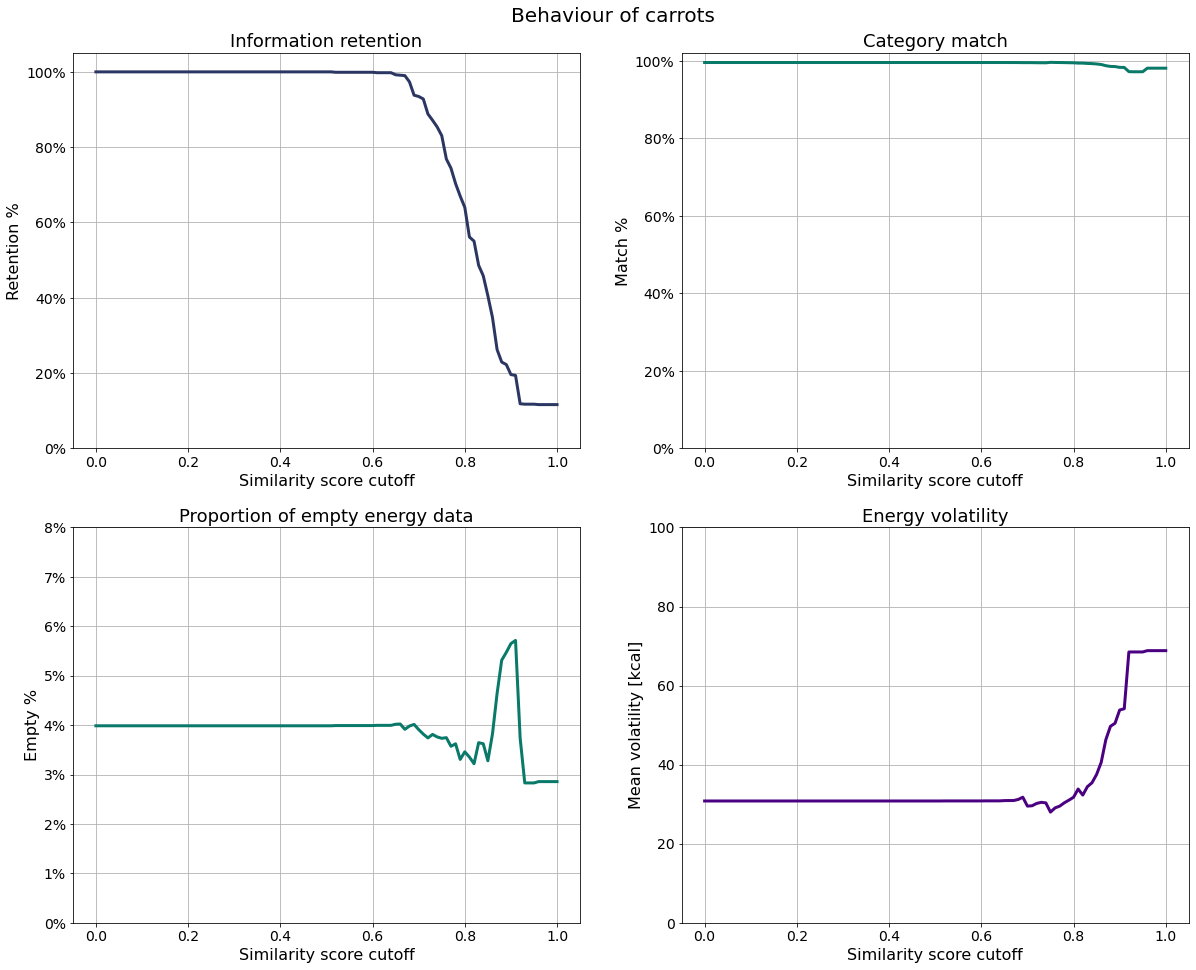

In [11]:
### Plot results for carrots

fig, axs = plt.subplots(2, 2, figsize = (20, 16))
X_LABEL = 'Similarity score cutoff'
LINEWIDTH = 3
VISIBILITY = True

# Plot retention
axs[0, 0].plot(df_sensibility_carrots['cutoff_score'],
              df_sensibility_carrots['preserved_rows'] * 100,
              color = '#2b3762',
              label = 'Ingredients preserved',
              lw = LINEWIDTH)

# Format retention
axs[0, 0].set_title('Information retention', fontsize = PLOT_SETUP['subtitle'])
axs[0, 0].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[0, 0].set_ylabel('Retention %', fontsize = PLOT_SETUP['label'])

axs[0, 0].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[0, 0].set_ylim([0, 105])

yticks = mticker.FormatStrFormatter('%.0f%%')
axs[0, 0].yaxis.set_major_formatter(yticks)
axs[0, 0].grid(visible = VISIBILITY)

# Plot category match
axs[0, 1].plot(df_sensibility_carrots['cutoff_score'],
              df_sensibility_carrots['category_match'] * 100,
              color = '#097969',
              lw = LINEWIDTH)

# Format category match
axs[0, 1].set_title('Category match', fontsize = PLOT_SETUP['subtitle'])
axs[0, 1].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[0, 1].set_ylabel('Match %', fontsize = PLOT_SETUP['label'])

axs[0, 1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[0, 1].set_ylim([0, 102])

axs[0, 1].yaxis.set_major_formatter(yticks)
axs[0, 1].grid(visible = VISIBILITY)

# Plot nulls
axs[1, 0].plot(df_sensibility_carrots['cutoff_score'],
              df_sensibility_carrots['null_energy'] * 100,
              color = '#097969',
              lw = LINEWIDTH)

# Format nulls
axs[1, 0].set_title('Proportion of empty energy data', fontsize = PLOT_SETUP['subtitle'])
axs[1, 0].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[1, 0].set_ylabel('Empty %', fontsize = PLOT_SETUP['label'])

axs[1, 0].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[1, 0].set_ylim([0, 8])

axs[1, 0].yaxis.set_major_formatter(yticks)
axs[1, 0].grid(visible = VISIBILITY)

# Plot volatility
axs[1, 1].plot(df_sensibility_carrots['cutoff_score'],
              df_sensibility_carrots['mean_volatility'],
              color = '#4b0082',
              lw = LINEWIDTH)

# Format volatility
axs[1, 1].set_title('Energy volatility', fontsize = PLOT_SETUP['subtitle'])
axs[1, 1].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[1, 1].set_ylabel('Mean volatility [kcal]', fontsize = PLOT_SETUP['label'])

axs[1, 1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[1, 1].set_ylim([0, 100])

axs[1, 1].grid(visible = VISIBILITY)

# Add title
plt.suptitle('Behaviour of carrots', fontsize = PLOT_SETUP['title'], y = 0.92) # Main title of the plot

plt.show()

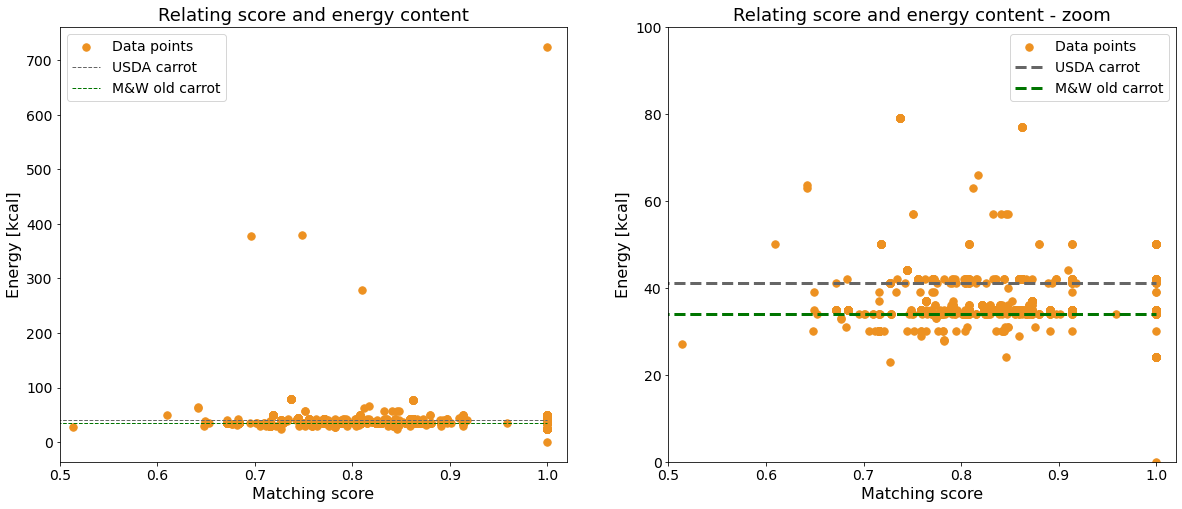

In [12]:
### Distribution of carrots

df_carrots_energy = df_carrots[df_carrots['energy_unit'] == 'kcal']
df_carrots_energy['energy_quantity'] = pd.to_numeric(df_carrots_energy['energy_quantity'])

# References
USDA_CARROT = 41
MW_CARROT = 34

COLOURS_CARROT = {'points': '#ed9121',
                 'usda': '#666666',
                 'mw': '#007500'}

# Define plots
fig, axs = plt.subplots(1, 2, figsize = (20, 8))

# Scatter plot
axs[0].scatter(df_carrots_energy['matched_score'],
               df_carrots_energy['energy_quantity'],
               color = COLOURS_CARROT['points'],
               s = 55,
               label = 'Data points')

axs[0].plot([0, 1],
            [USDA_CARROT] * 2,
            color = COLOURS_CARROT['usda'],
            lw = 1,
            linestyle = '--',
            label = 'USDA carrot')

axs[0].plot([0, 1],
            [MW_CARROT] * 2,
            color = COLOURS_CARROT['mw'],
            lw = 1,
            linestyle = '--',
            label = 'M&W old carrot')

# Format plot
axs[0].set_title('Relating score and energy content', fontsize = PLOT_SETUP['subtitle'])
axs[0].set_xlabel('Matching score', fontsize = PLOT_SETUP['label'])
axs[0].set_ylabel('Energy [kcal]', fontsize = PLOT_SETUP['label'])

axs[0].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[0].legend(loc = 'best', fontsize = PLOT_SETUP['legend'])
axs[0].set_xlim([0.5, 1.02])

# Scatter plot - zoom
axs[1].scatter(df_carrots_energy['matched_score'],
               df_carrots_energy['energy_quantity'],
               color = COLOURS_CARROT['points'],
               s = 55,
               label = 'Data points')

axs[1].plot([0, 1],
            [USDA_CARROT] * 2,
            color = COLOURS_CARROT['usda'],
            lw = 3,
            linestyle = '--',
            label = 'USDA carrot')

axs[1].plot([0, 1],
            [MW_CARROT] * 2,
            color = COLOURS_CARROT['mw'],
            lw = 3,
            linestyle = '--',
            label = 'M&W old carrot')

# Format plot - zoom
axs[1].set_title('Relating score and energy content - zoom', fontsize = PLOT_SETUP['subtitle'])
axs[1].set_xlabel('Matching score', fontsize = PLOT_SETUP['label'])
axs[1].set_ylabel('Energy [kcal]', fontsize = PLOT_SETUP['label'])

axs[1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[1].legend(loc = 'best', fontsize = PLOT_SETUP['legend'])
axs[1].set_xlim([0.5, 1.02])
axs[1].set_ylim([0, 100])

plt.show()

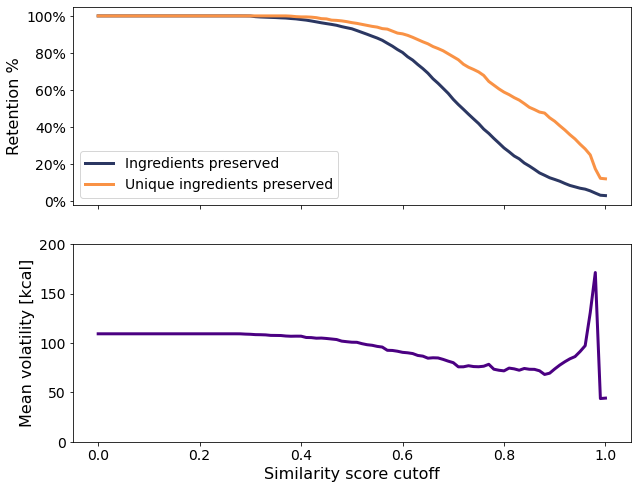

In [26]:
### Presentation plots - all ingredients

fig, axs = plt.subplots(2, 1, figsize = (10, 8), sharex = True)
X_LABEL = 'Similarity score cutoff'
LINEWIDTH = 3
VISIBILITY = True

# Plot retention
axs[0].plot(df_sensibility['cutoff_score'],
              df_sensibility['preserved_rows'] * 100,
              color = '#2b3762',
              label = 'Ingredients preserved',
              lw = LINEWIDTH)

axs[0].plot(df_sensibility['cutoff_score'],
              df_sensibility['ingredients_retained'] * 100,
              color = '#f99245',
              label = 'Unique ingredients preserved',
              lw = LINEWIDTH)

# Format retention
# axs[0].set_title('Information retention', fontsize = PLOT_SETUP['subtitle'])
# axs[0].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[0].set_ylabel('Retention %', fontsize = PLOT_SETUP['label'])

axs[0].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[0].legend(loc = 'best', fontsize = PLOT_SETUP['legend'])

axs[0].yaxis.set_major_formatter(yticks)
# axs[0].grid(visible = VISIBILITY)

# Plot volatility
axs[1].plot(df_sensibility['cutoff_score'],
              df_sensibility['mean_volatility'],
              color = '#4b0082',
              lw = LINEWIDTH)

# Format volatility
# axs[1].set_title('Energy volatility', fontsize = PLOT_SETUP['subtitle'])
axs[1].set_xlabel(X_LABEL, fontsize = PLOT_SETUP['label'])
axs[1].set_ylabel('Mean volatility [kcal]', fontsize = PLOT_SETUP['label'])

axs[1].tick_params(axis = 'both', which = 'major', labelsize = PLOT_SETUP['tick'])
axs[1].set_ylim([0, 200])

# axs[1].grid(visible = VISIBILITY)

# Add title
# plt.suptitle('Behaviour at threshold of similarity score', fontsize = PLOT_SETUP['title'], y = 0.92) # Main title of the plot

plt.show()

In [29]:
df_carrots_energy.sort_values(by = 'energy_quantity', ascending = False).head()

,ingredient_id,original_ingredient_name,matched_ingredient,matched_score,ingredient_category_id,taxonomy_category_id,nutrition_id,has_nutrition_data,energy_quantity,energy_unit,...,salt_quantity,salt_unit,fat_quantity,fat_unit,saturated_fat_quantity,saturated_fat_unit,carbohydrate_quantity,carbohydrate_unit,sugar_quantity,sugar_unit
65811,1228602,"Prep - Peeled, Washed Carrots",carrots,1.000000,103,103,1477085,1,725.0,kcal,...,1.5,g,12.5,g,2.5,g,107.5,g,102.5,g
52991,1112891,Brakes Carrot Cake,carrots,0.747906,107,103,1362690,1,379.0,kcal,...,0.49,g,21,g,6,g,42,g,32,g
53941,1125114,Carrot Cake Mix Pre-order 12.5k,carrots,0.696207,103,103,1373815,1,377.0,kcal,...,2.2,g,4.7,g,0.3,g,76.6,g,43.7,g
5798,685192,Carrot Powder,carrots,0.810247,103,103,936338,1,279.0,kcal,...,1.13,g,1.8,g,0.3,g,40.7,g,39.3,g
34312,975837,Premium Selection Orange & Honey Chantenay Car...,carrots,0.737001,103,103,1226195,1,79.0,kcal,...,0.48,g,4,g,0.4,g,8.7,g,8.6,g


In [31]:
np.mean(df_carrots_energy['energy_quantity'])

39.67128237944636